In [168]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np
import project_utils.binary_classification as bc
importlib.reload(bc)

utils.default_plot_format()
utils.pd_display_settings(3)

In [169]:
#data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
data_path = r"processed_data\raw_metrics\comorbidities.pkl"

In [170]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()


,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
4115,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4116,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4117,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4118,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
4119,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [171]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


# helper functions


In [172]:
def classify_by_feat(data, features):
    print(features)
    log_res, X_scaled, y = bc.logistic_classifier(data, features)
    res = bc.eval_model(log_res, X_scaled, y)

    bc.plot_evaluation_metrics(res, data['DPN'], f"Logistic Regression Evaluation n={len(data)}", (10, 7))
    return res

In [173]:
def plot_vif(data:pd.DataFrame, height=5):
    nan_columns = data[data.isna().any(axis=1)]["feature"].tolist()
    melted_data = data.melt(id_vars=["feature"], value_vars=["Full VIF", "Excluded VIF"], var_name="VIF Type", value_name="VIF Value")
    plt.figure(figsize=(8, height))
   
    sns.barplot(x="VIF Value", y="feature", hue="VIF Type", data=melted_data, dodge=True)
    plt.title(f"VIF for HRV metrics; Excluded variables: {nan_columns}")
    plt.legend()
    plt.xscale('log')
    plt.grid(axis='x', linestyle='-', alpha=0.5)
    plt.grid(axis='x', linestyle='--', which='minor',alpha = 0.5)
    plt.tight_layout()
    plt.show()

# LDA

In [174]:
median = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

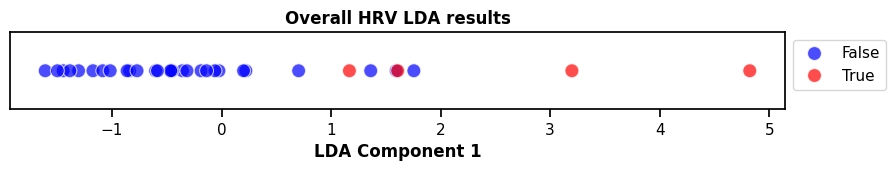

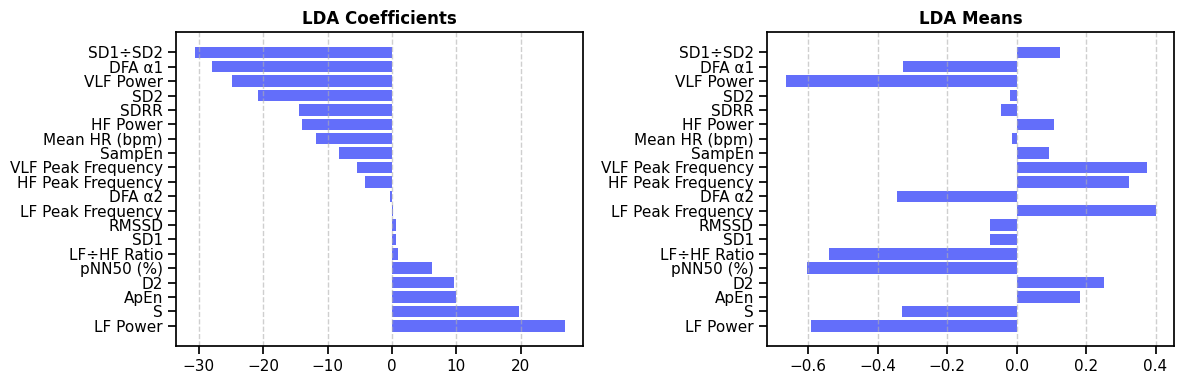

In [175]:
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results")
df = LV.show_linear_lda_stats(lda, indicator_columns) 

In [176]:
from IPython.display import display
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)


Columns,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,HF Power,HF Peak Frequency,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
LDA Coef,-14.50,0.60,6.22,-11.74,-24.89,-5.42,26.79,0.12,-14.00,-4.26,0.93,19.76,0.60,-20.83,-30.66,9.91,-8.26,-28.00,-0.26,9.64
Means,-0.0456,-0.0764,-0.60,-0.0146,-0.66,0.38,-0.59,0.40,0.11,0.32,-0.54,-0.33,-0.0764,-0.0183,0.13,0.18,0.0947,-0.33,-0.34,0.25


LDA allows to isolate all of the DPN patients by over-fitting.

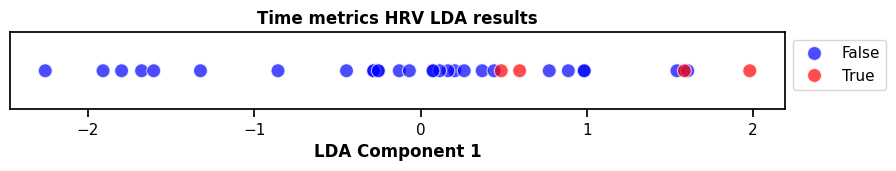

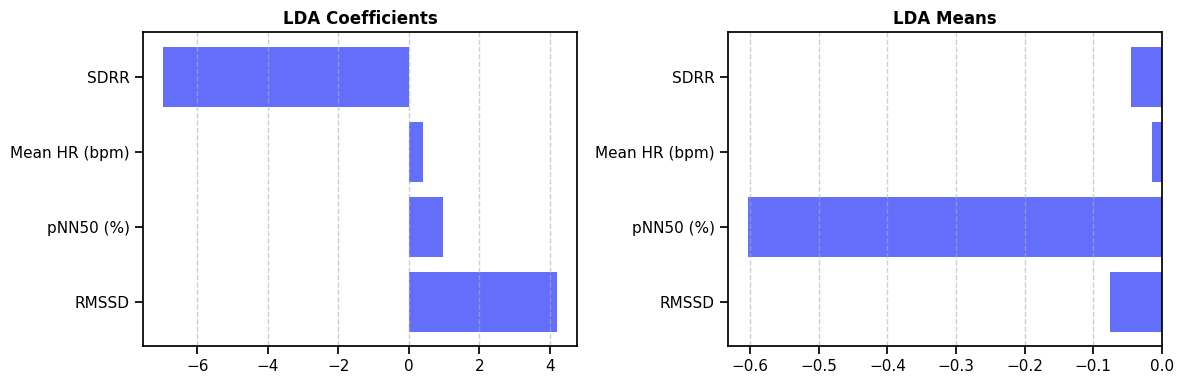

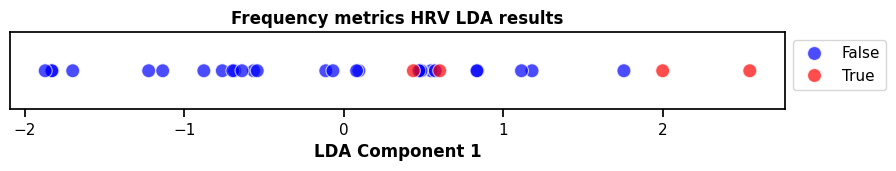

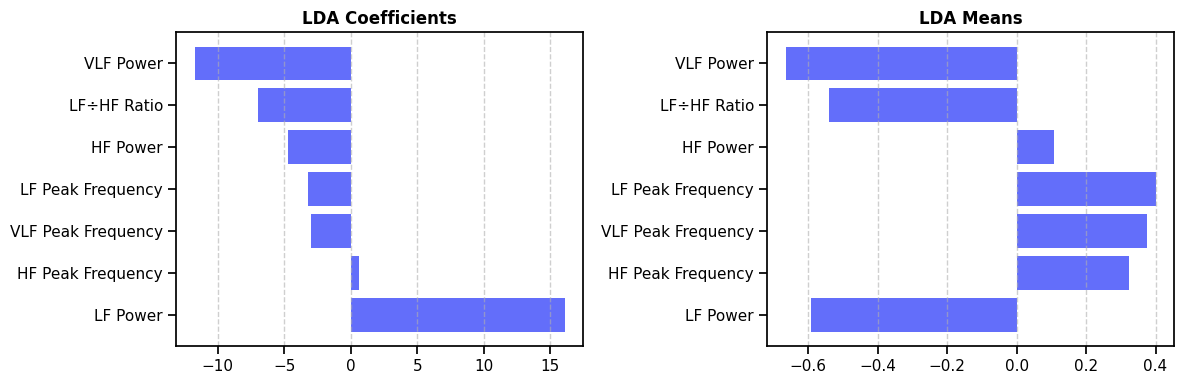

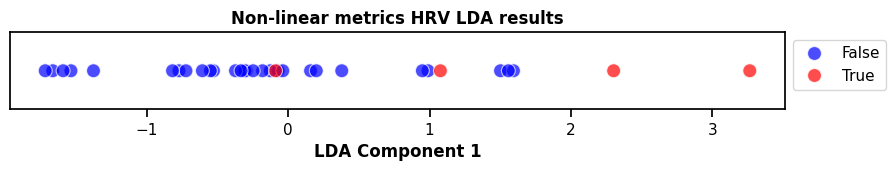

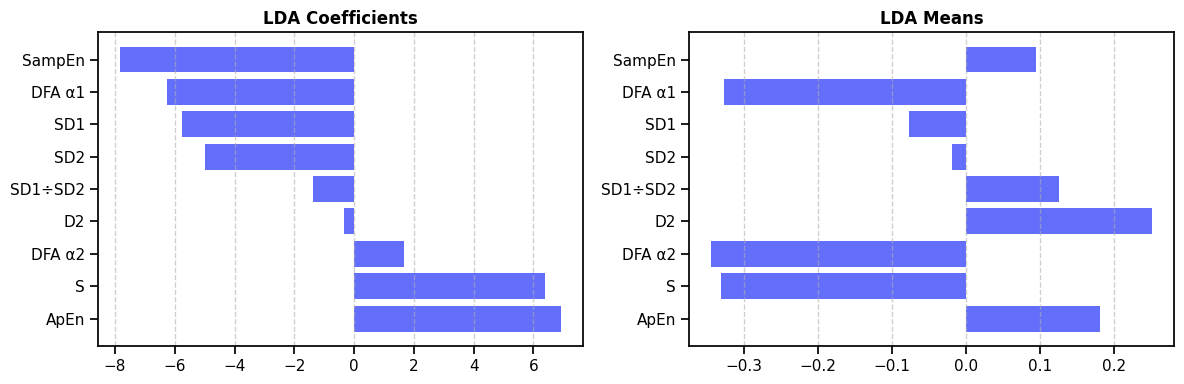

In [177]:
metric_lda = [] 
for col, name in zip([time_metrics, frequency_metrics, non_linear_metrics], ["Time", "Frequency", "Non-linear"]):
    lda_df, lda = LV.perform_lda(median_pivot, col)
    LV.plot_linear_lda(lda_df,  f"{name} metrics HRV LDA results")
    LV.show_linear_lda_stats(lda, col)
    metric_lda.append([lda, lda_df, name])


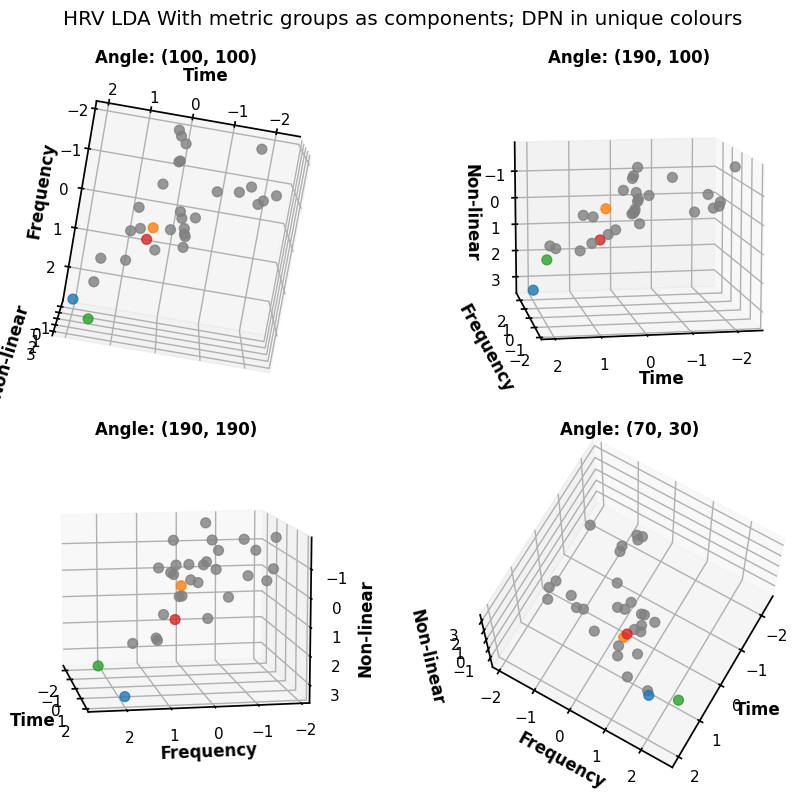

In [178]:
full_df = pd.DataFrame()
for lda, lda_df, name in metric_lda:
    full_df[name] = lda_df[0]
    
full_df["cluster"] = metric_lda[0][1]["Cluster"]


unique_dpn = full_df[full_df['cluster']].index
dpn_colors = {idx: color for idx, color in zip(unique_dpn, mcolors.TABLEAU_COLORS)}

fig = plt.figure(figsize=(10, 8))

# Define the angles for the subplots
angles = [(100, 100), (190, 100), (190, 190), (70, 30)]

fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax.scatter(full_df['Time'], full_df['Frequency'], full_df['Non-linear'], 
               c=[dpn_colors[idx] if idx in dpn_colors else 'gray' for idx in full_df.index], 
               s=50, alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Non-linear')
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'Angle: {angle}')

plt.suptitle('HRV LDA With metric groups as components; DPN in unique colours')
plt.tight_layout()
plt.show()

### LDA Man whitney >0.10

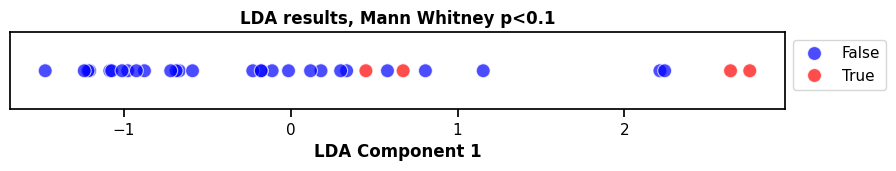

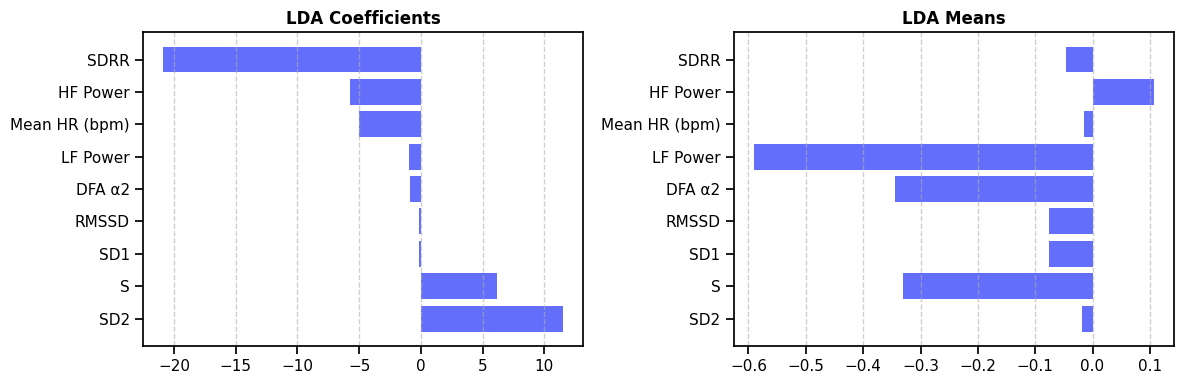

In [179]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Mann Whitney p<0.1")
df = LV.show_linear_lda_stats(lda, col)

# LDA permutations <0.1

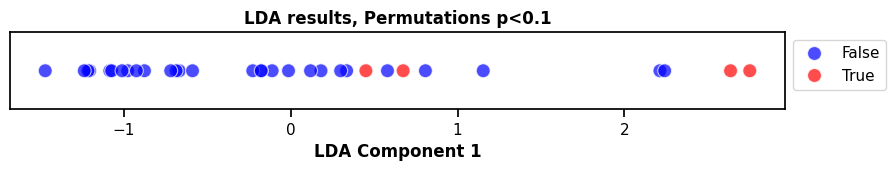

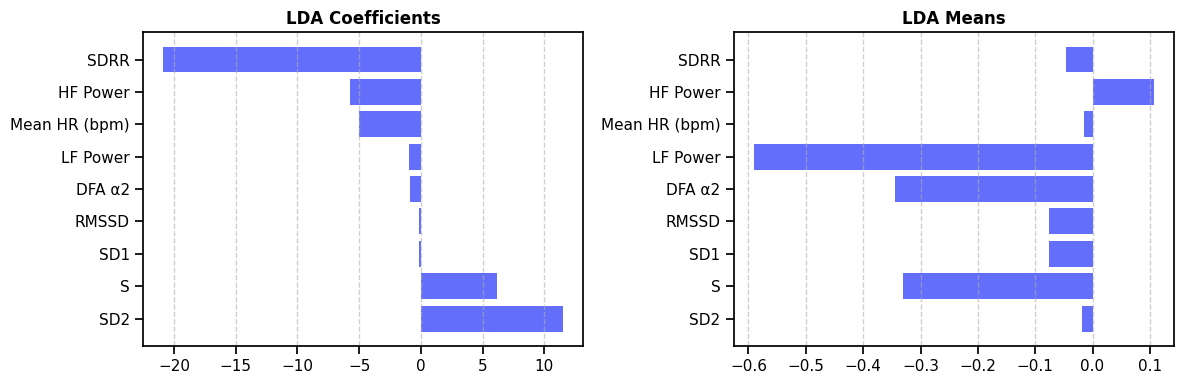

In [180]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Permutations p<0.1")
df = LV.show_linear_lda_stats(lda, col)

In [181]:
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)

Columns,HF Power,SD2,SDRR,Mean HR (bpm),LF Power,DFA α2,S,RMSSD,SD1
LDA Coef,-5.72,11.51,-20.90,-5.01,-0.95,-0.86,6.16,-0.15,-0.14
Means,0.11,-0.0183,-0.0456,-0.0146,-0.59,-0.34,-0.33,-0.0764,-0.0764


# Classifier and LDA

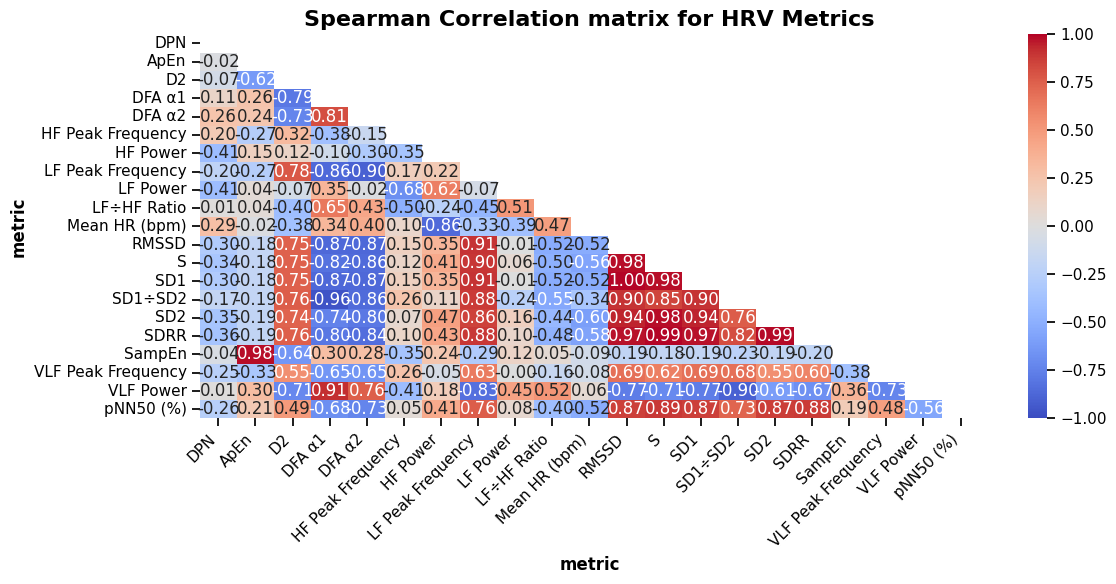

In [182]:
LV.show_correlation(median_pivot.drop(columns='id'), "Spearman Correlation matrix for HRV Metrics")

In [183]:
import general_utils.LDI_VIF as LV
importlib.reload(LV)

LV.get_vif(median.drop(columns =['id', 'DPN']), ['SDRR', 'VLF Power'])

,feature,Full VIF,Excluded VIF
12,SD1,7620323279,7615265750
10,RMSSD,7620175001,7615124107
0,ApEn,3955,2923
16,SampEn,2310,1641
9,Mean HR (bpm),1311,940.83
2,DFA α1,1029,818.17
17,VLF Peak Frequency,1026,485.08
6,LF Peak Frequency,595.75,374.12
13,SD1÷SD2,401.70,356.77
3,DFA α2,310.87,310.03


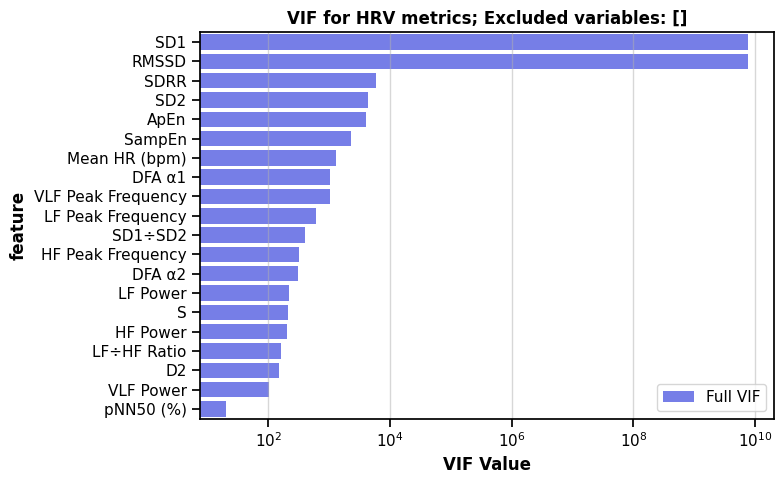

In [184]:


LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))

Log classifier fails to converge, because a separation could not be identified.

## LDA feature isolation

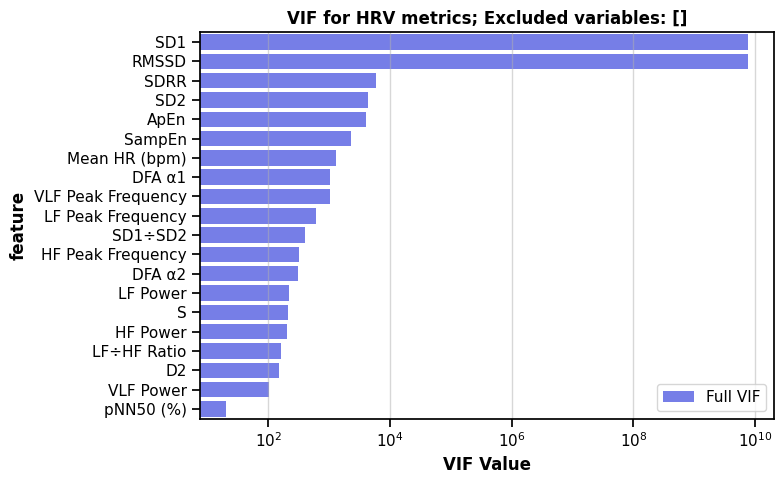

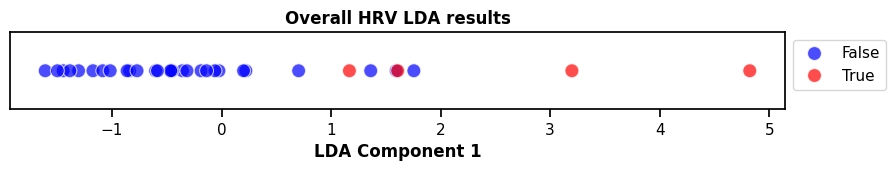

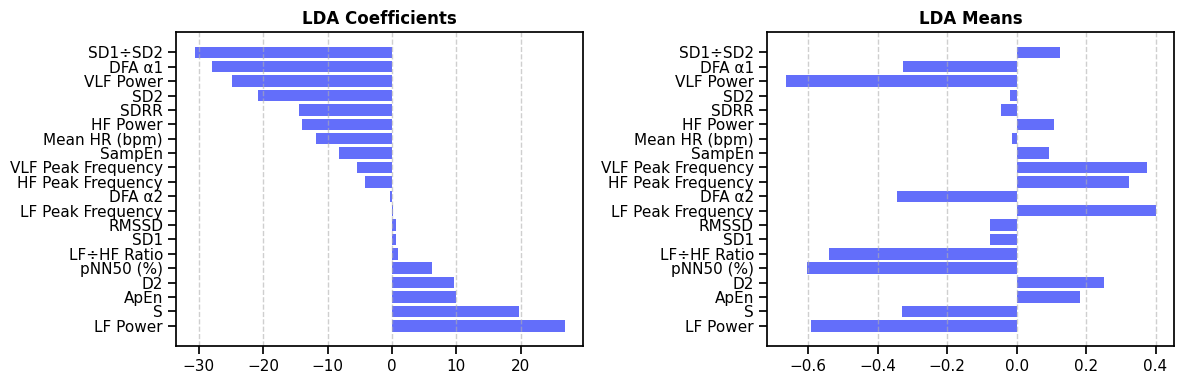

In [185]:
LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results")
df = LV.show_linear_lda_stats(lda, indicator_columns)


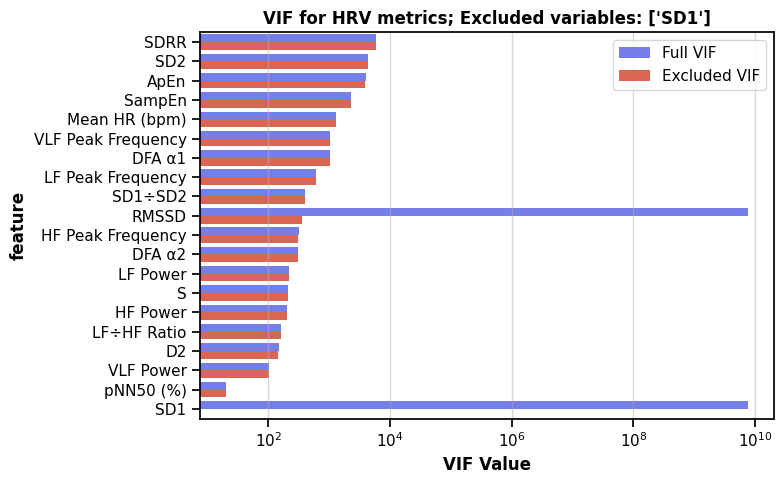

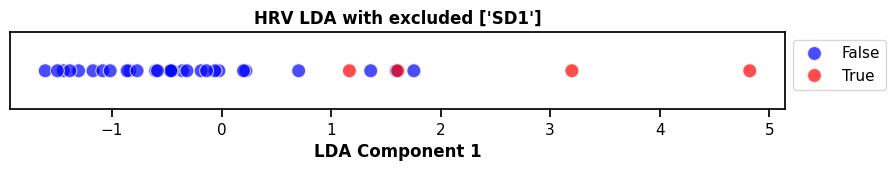

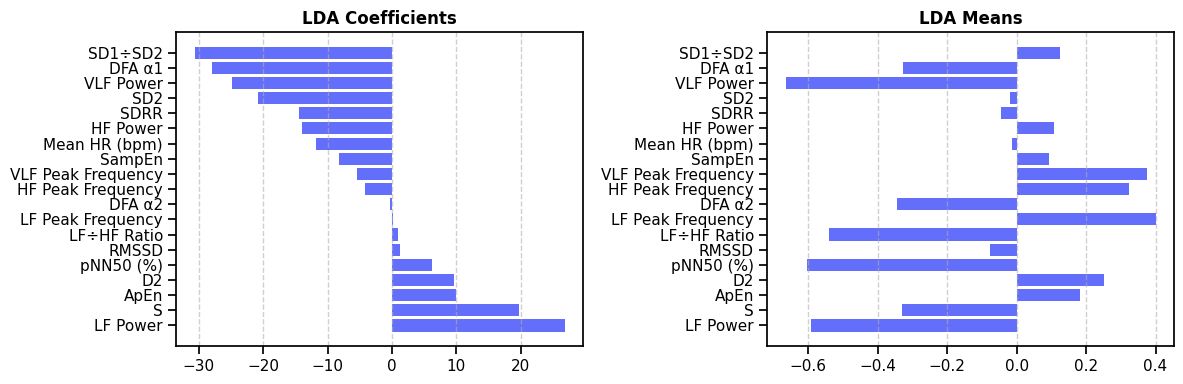

In [186]:
LV.lda_vif_exclude(median, 'SD1')
median = median.drop(columns ='SD1')

SD can be very easily excluded

In [187]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

index.columns

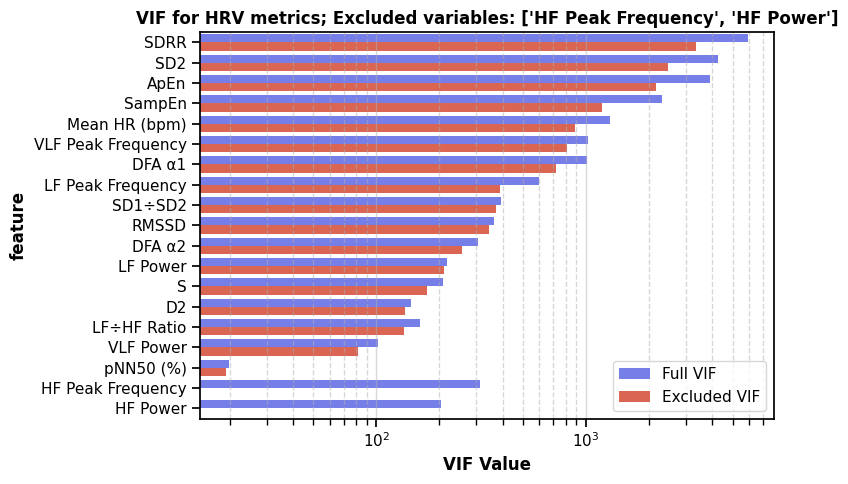

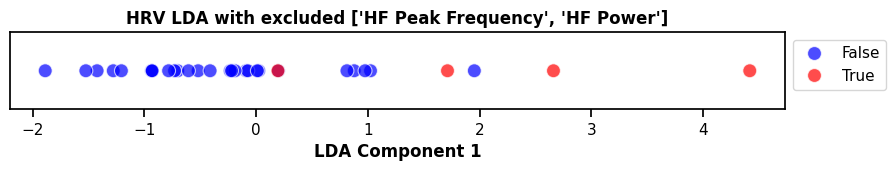

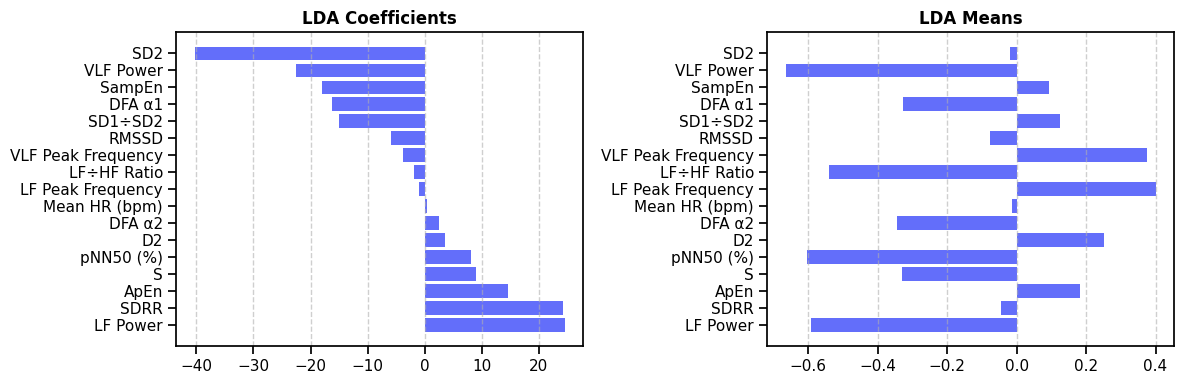

In [188]:
LV.lda_vif_exclude(median, ['HF Peak Frequency', 'HF Power'])
median = median.drop(columns =['HF Peak Frequency', 'HF Power'])


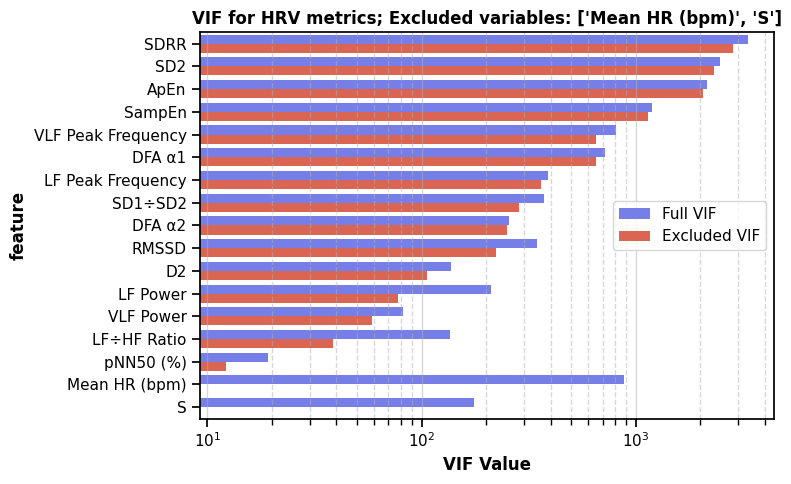

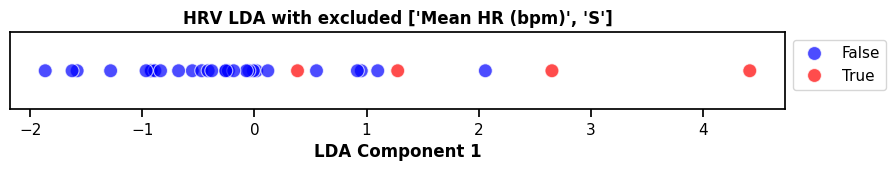

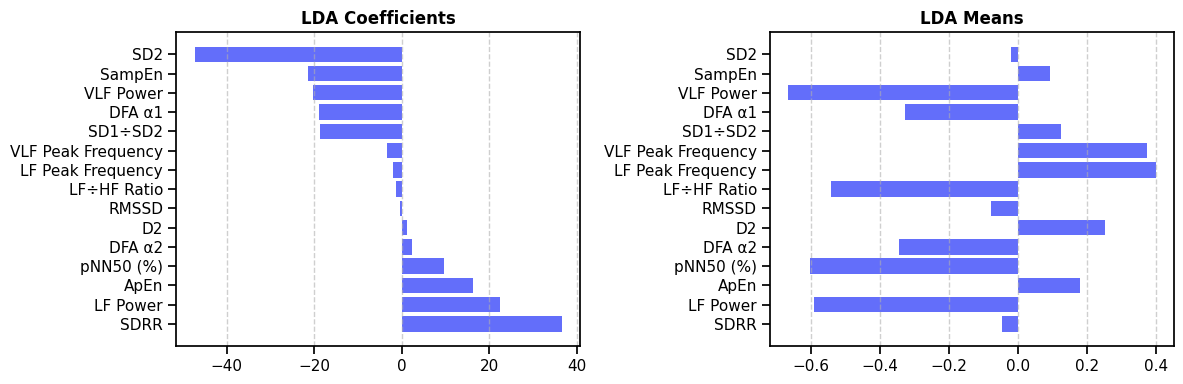

In [189]:
LV.lda_vif_exclude(median, ['Mean HR (bpm)', 'S'])
median = median.drop(columns =['Mean HR (bpm)', 'S'])

In [190]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF Power', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

SD2 is too important for separation to drop

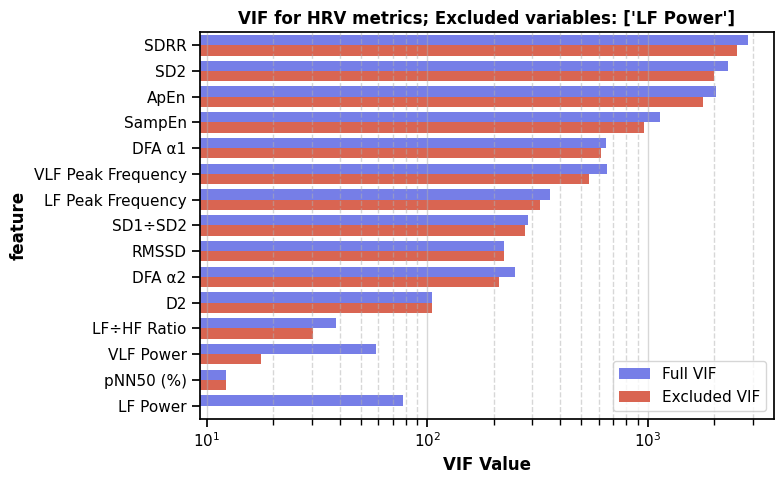

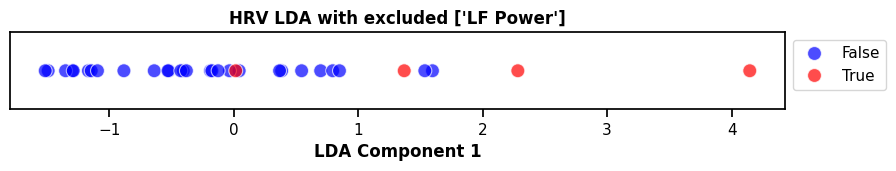

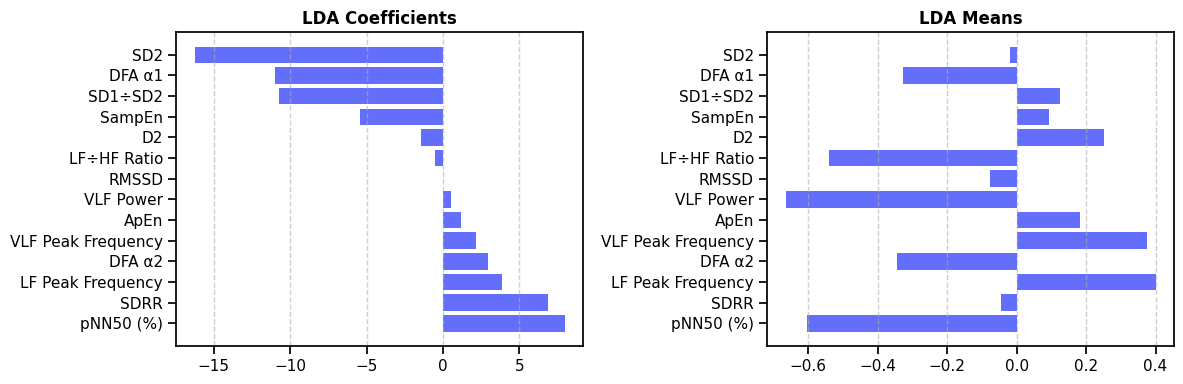

In [191]:
LV.lda_vif_exclude(median, ['LF Power', ])
median = median.drop(columns =['LF Power'])


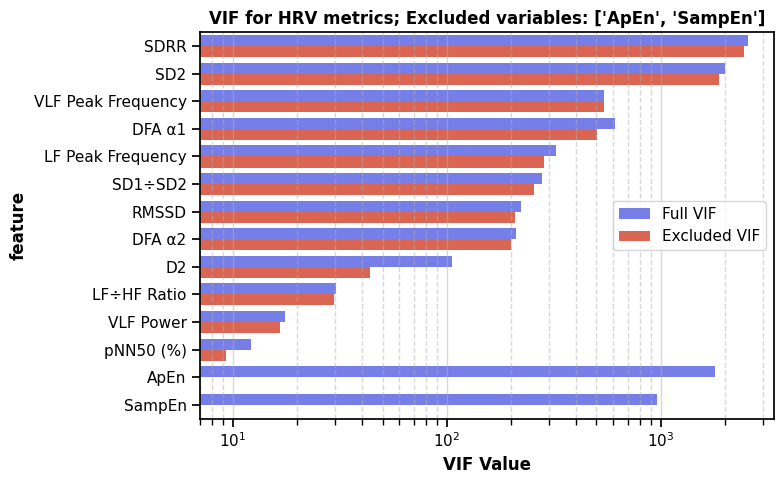

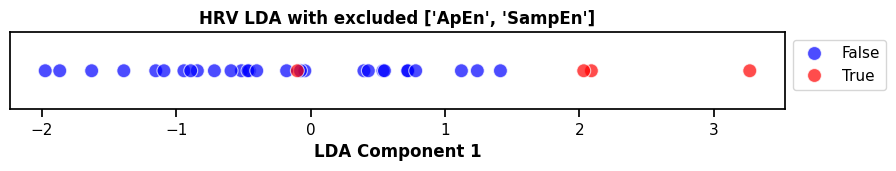

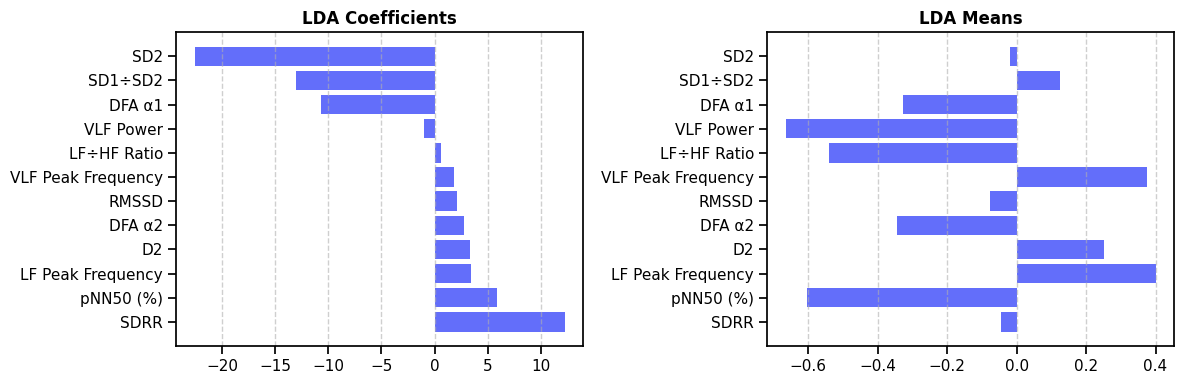

In [192]:
LV.lda_vif_exclude(median, ['ApEn', 'SampEn'])
median = median.drop(columns =['ApEn', 'SampEn'])

In [193]:
median.columns

Index(['id', 'DPN', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency',
       'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

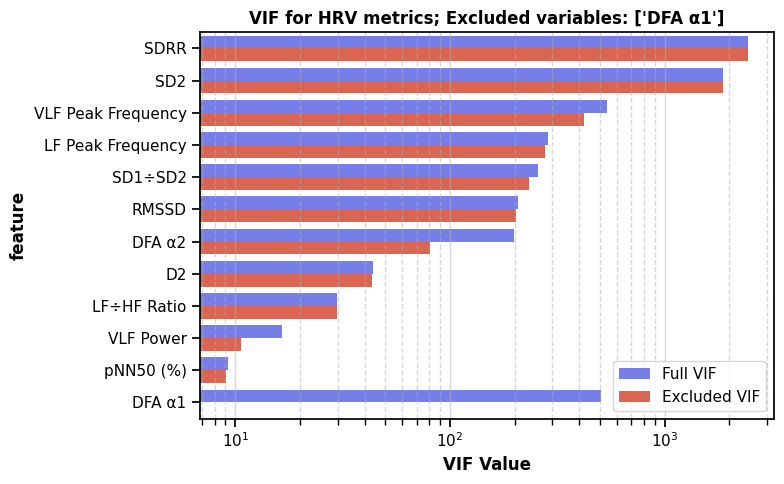

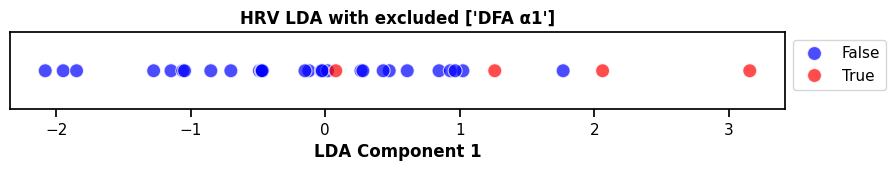

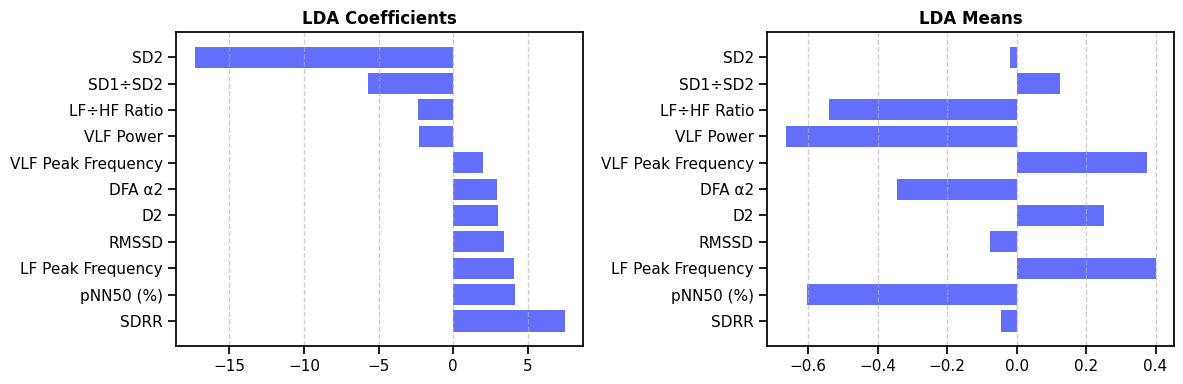

In [194]:
LV.lda_vif_exclude(median, ['DFA α1'])
data.drop(columns =['DFA α1']);


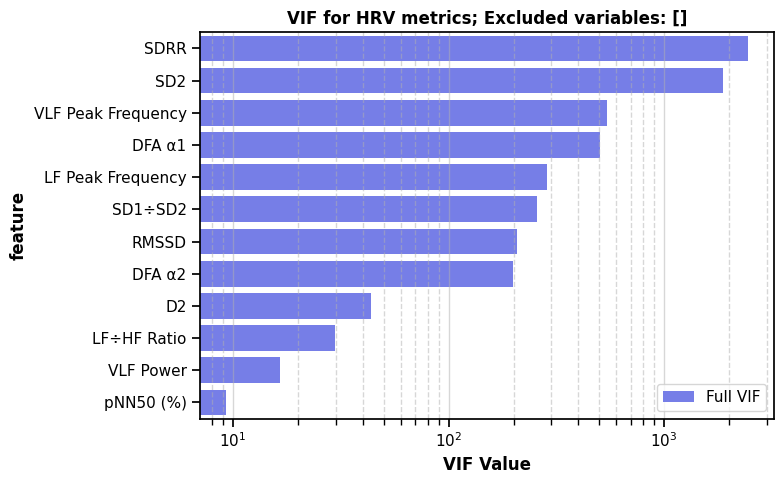

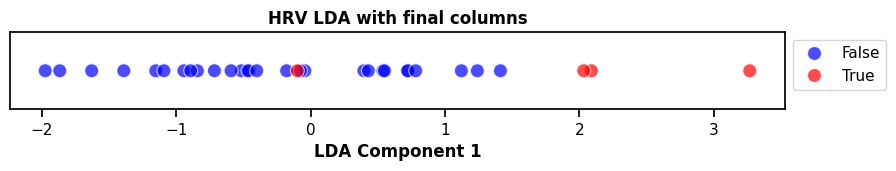

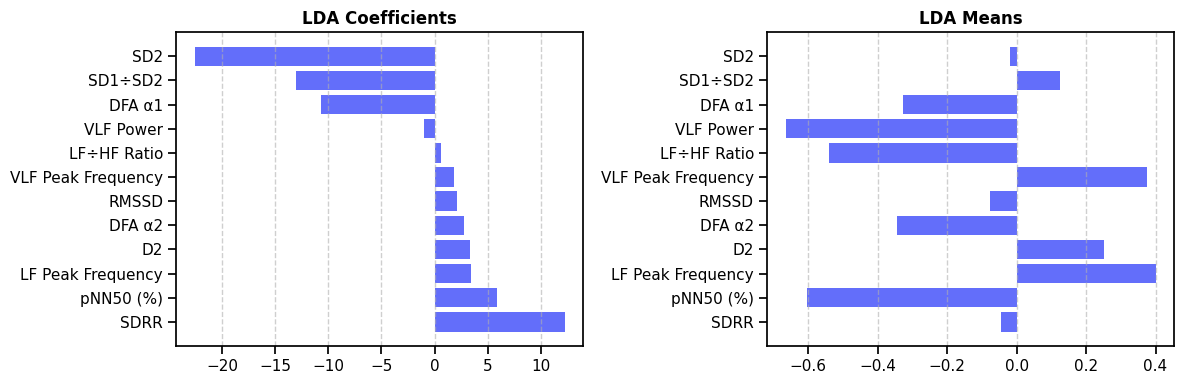

In [195]:
def show_current_lda(median, title = "HRV LDA with final columns"):
    columns = [columns for columns in median.columns if columns not in ['id', 'DPN']]

    LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
    lda_df, lda = LV.perform_lda(median, columns)
    LV.plot_linear_lda(lda_df, title)
    LV.show_linear_lda_stats(lda, columns)

show_current_lda(median)

### Result interpretation

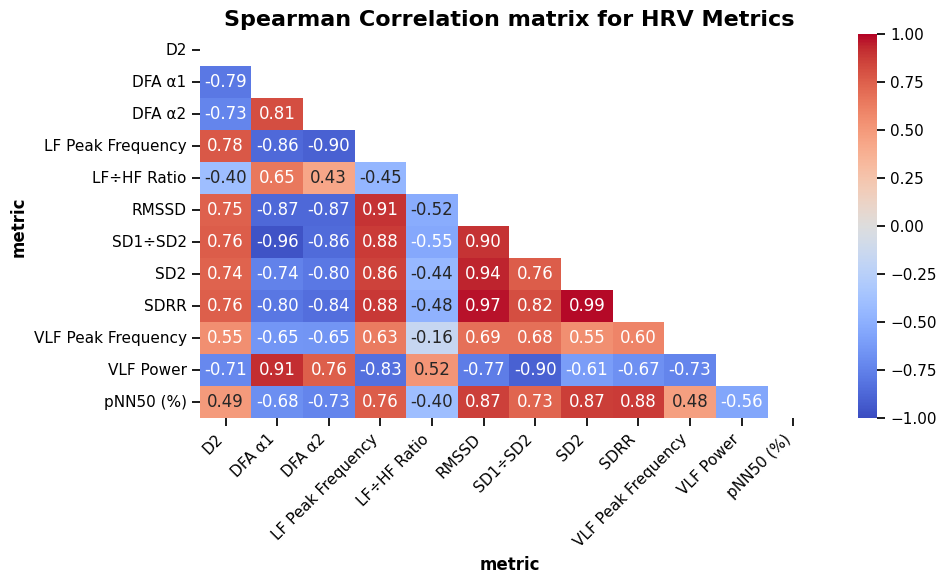

In [196]:
LV.show_correlation(median.drop(columns=['id', 'DPN']), "Spearman Correlation matrix for HRV Metrics", (10,6))

In [197]:
try:
    features = [columns for columns in median.columns if columns not in ['id', 'DPN']]
    classify_by_feat(median, features)
except:
    print("Error in classification")

['D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)']
         Current function value: inf
         Iterations: 1000
Error in classification


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


## Sacrifice of predictive power for separation

In [198]:
median.columns

Index(['id', 'DPN', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency',
       'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

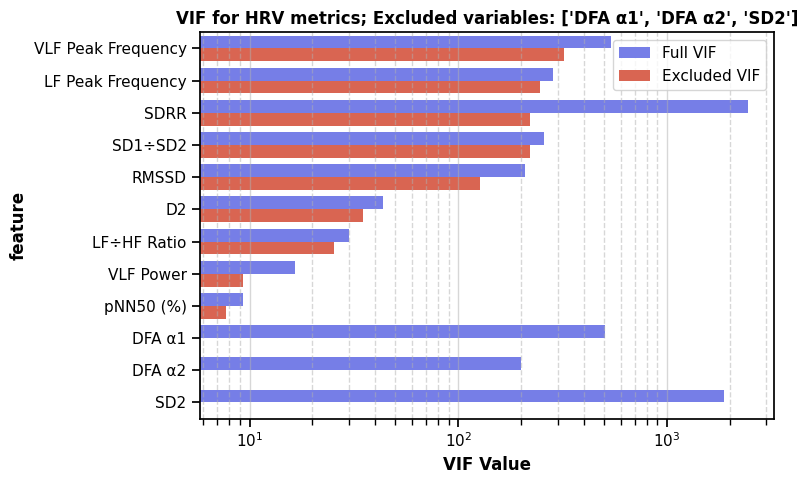

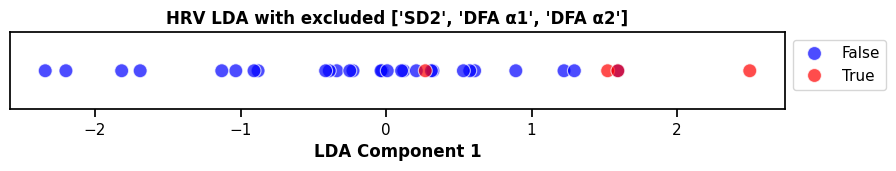

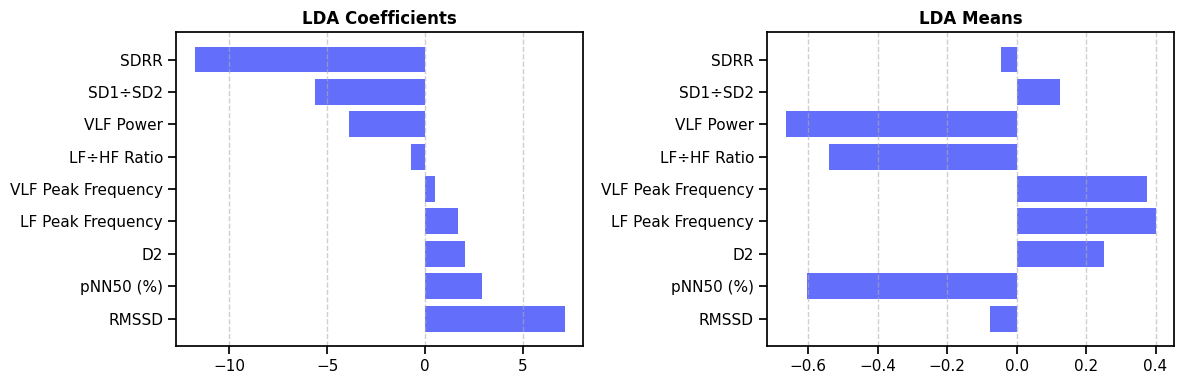

In [199]:
LV.lda_vif_exclude(median, ['SD2','DFA α1', 'DFA α2'])
less_sep = median.copy().drop(columns = ['SD2','DFA α1', 'DFA α2'])


In [200]:
try:
    features = [columns for columns in less_sep.columns if columns not in ['id', 'DPN']]
    classify_by_feat(less_sep, features)
except:
    print("Error in classification")

['D2', 'LF Peak Frequency', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SDRR', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)']
         Current function value: inf
         Iterations: 1000
Error in classification


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Removal of SD2 produces very tight distribution for all but one component.

# Automatic VIF LDA

Removed: SD1
Removed: SDRR
Removed: ApEn
Removed: Mean HR (bpm)
Removed: VLF Peak Frequency
Removed: DFA α1
Removed: LF Peak Frequency
Removed: RMSSD
Removed: HF Peak Frequency
Removed: SD2
Removed: DFA α2
Removed: SampEn
Removed: LF Power
Removed: SD1÷SD2
Remaining features: ['D2', 'HF Power', 'LF÷HF Ratio', 'S', 'VLF Power', 'pNN50 (%)']


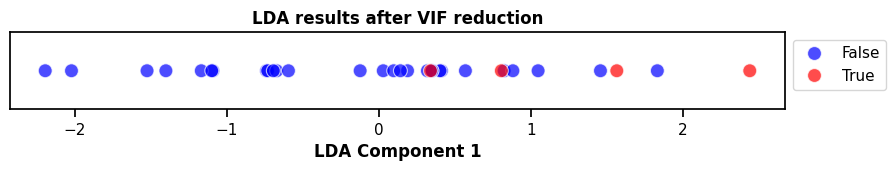

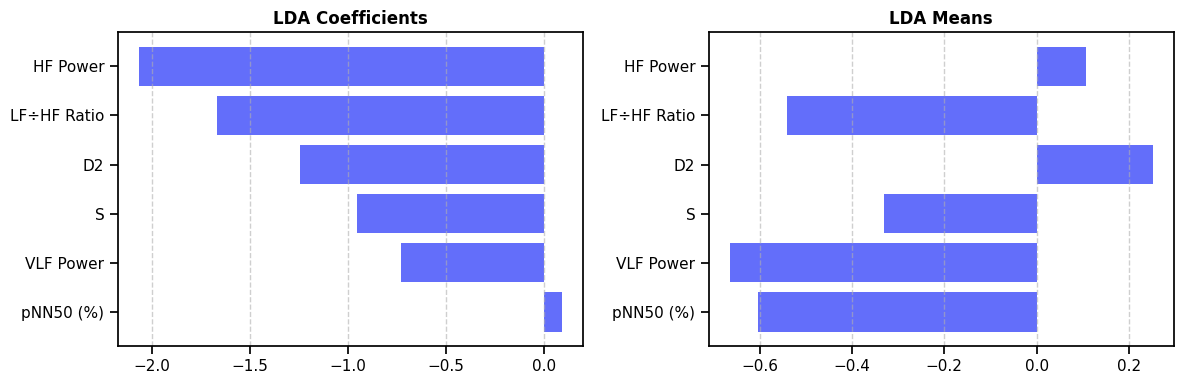

,Columns,LDA Coef,Means
0,D2,-1.24,0.25
1,HF Power,-2.07,0.11
2,LF÷HF Ratio,-1.67,-0.54
3,S,-0.95,-0.33
4,VLF Power,-0.73,-0.66
5,pNN50 (%),0.0918,-0.60


In [ ]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)

vif_median = median_pivot.copy()
removed_features = []

for _ in range(13):
    vif_data = LV.get_vif(vif_median.drop(columns=['id', 'DPN']))
    max_vif_value = vif_data["Full VIF"].max()
    if max_vif_value < 5:
        break
    max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
    vif_median = vif_median.drop(columns=[max_vif_col])
    removed_features.append(max_vif_col)
    print(f"Removed: {max_vif_col}")

remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
print(f"Remaining features: {remaining_features}")
lda_df, lda = LV.perform_lda(vif_median, remaining_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, remaining_features)

#print(lda_df)


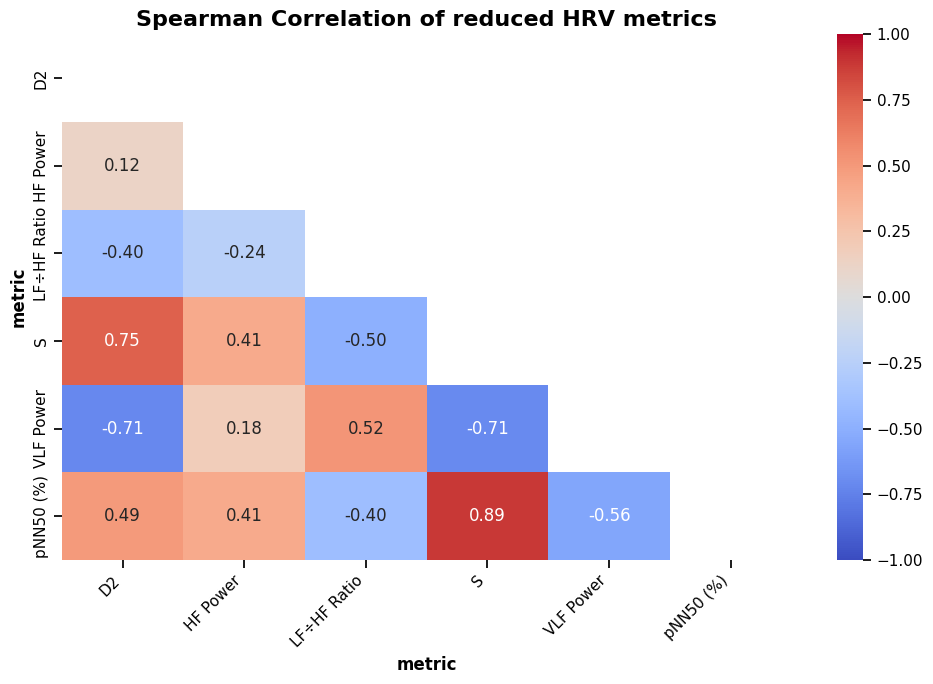

In [202]:
LV.show_correlation(vif_median.drop(columns=['id', 'DPN']), "Spearman Correlation of reduced HRV metrics", (10,7))


['D2', 'HF Power', 'LF÷HF Ratio', 'S', 'VLF Power', 'pNN50 (%)']
Optimization terminated successfully.
         Current function value: 0.217209
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    DPN   No. Observations:                   32
Model:                          Logit   Df Residuals:                       25
Method:                           MLE   Df Model:                            6
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                  0.4235
Time:                        14:57:38   Log-Likelihood:                -6.9507
converged:                       True   LL-Null:                       -12.057
Covariance Type:            nonrobust   LLR p-value:                    0.1160
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6509      2.020     -2.302

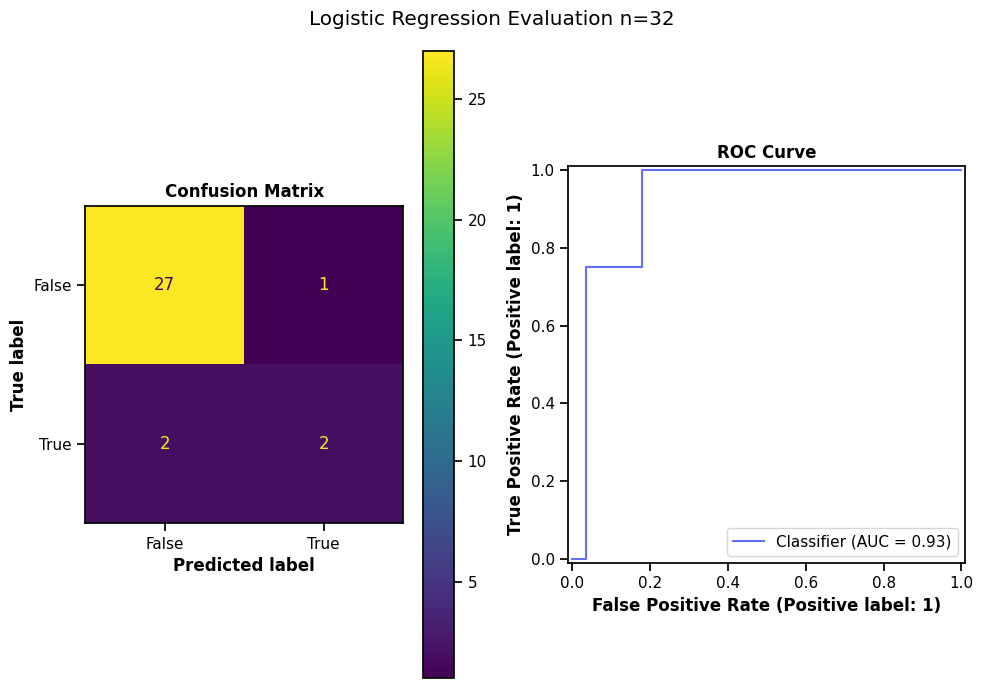

In [203]:
old_features = ['D2', 'SD1÷SD2', 'S', 'VLF Power', 'pNN50 (%)']
res = classify_by_feat(median_pivot, remaining_features);

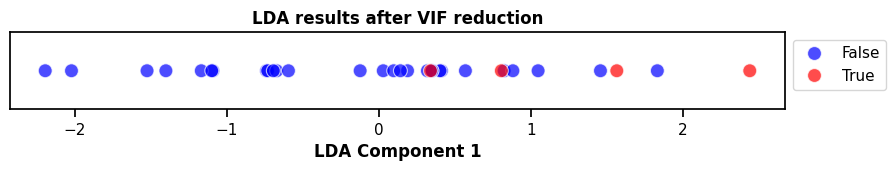

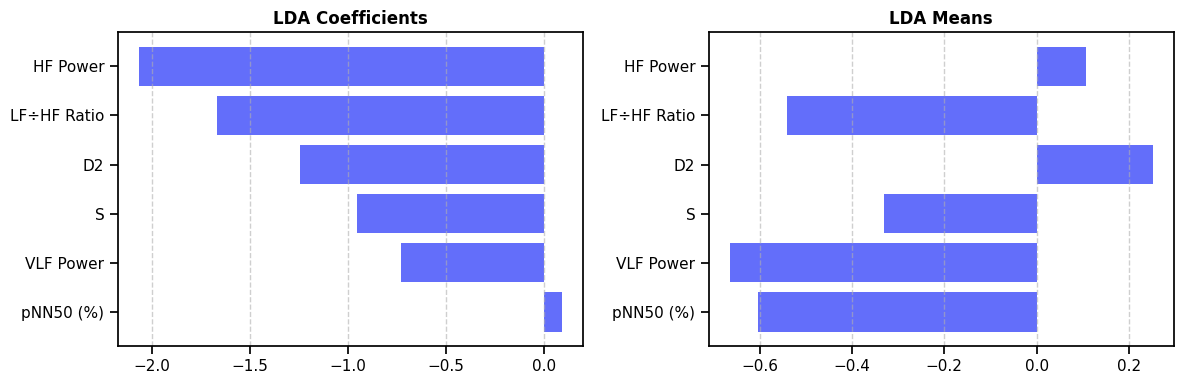

,Columns,LDA Coef,Means
0,D2,-1.24,0.25
1,HF Power,-2.07,0.11
2,LF÷HF Ratio,-1.67,-0.54
3,S,-0.95,-0.33
4,VLF Power,-0.73,-0.66
5,pNN50 (%),0.0918,-0.60


In [204]:
lda_df, lda = LV.perform_lda(median_pivot, remaining_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, remaining_features)